# 1. Path Setups

In [15]:
import os
import glob
import cv2 
import time
import base64
import requests
import numpy as np
import matplotlib.pyplot as plt
import imutils
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont, ImageFilter
from roboflow import Roboflow
import json
from Labels import labels
from IPython.display import clear_output
import warnings

warnings.filterwarnings('ignore')

In [2]:
ROBOFLOW_API_KEY = "mAx8l6o3PPZKYQReFKQg"
ROBOFLOW_MODEL = "car-plates-jvked/3"
ROBOFLOW_SIZE = 416

In [3]:
paths = {
    'IMAGE_PATH': os.path.join('codes', 'workspace','images'),
 }

# 2. Image Preprocessing and Number Plate Recognition With YOLOv8 From RoboFlow

In [34]:
rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace().project("car-plates-jvked")
model = project.version(4).model

loading Roboflow workspace...
loading Roboflow project...


In [30]:
ORIGINAL_IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'plates', '*ers.jpg')
ORIGINAL_IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'plates')
origina_image_paths = list(glob.glob(ORIGINAL_IMAGE_PATH))

In [31]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'plates', '*.png')
images_path= list(glob.glob(IMAGE_PATH))
# images_path[-3:-1]
# images_path = images_path[-3:-2]
images_path

['codes\\workspace\\images\\plates\\IMG_6801.png']

In [32]:
print(f'There are {len(images_path):,} images in the plates dataset')

There are 1 images in the plates dataset


1it [00:09,  9.69s/it]


أ و ٥ ١ ٦ 

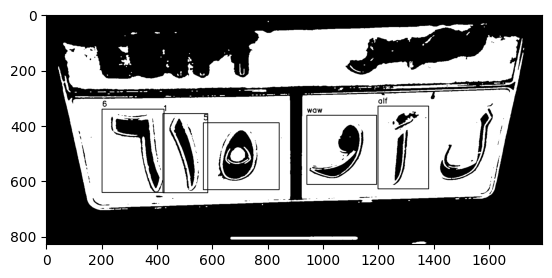

In [40]:
for i, image in tqdm(enumerate(images_path)):
    img = cv2.imread(image)
    # img_scaled = cv2.resize(img, None, fx=4, fy=4, interpolation = cv2.INTER_LANCZOS4)
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    blur = cv2.GaussianBlur(gray_image, (7,7), 0)

    _, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))

    # Apply dilation to thicken the font
    dilated = cv2.dilate(th3, kernel, iterations=1)

    # Apply erosion to shrink the text regions back to their original size
    eroded = cv2.erode(dilated, kernel, iterations=1)


    eroded = cv2.bitwise_not(eroded)


    y_hat= model.predict(eroded, confidence=50, overlap=40).json()
    predictions = y_hat['predictions']


    # sort the predictions based on the `x` coordinate of each bounding box
    predictions_sorted = sorted(predictions, key=lambda x: x['x'],reverse=True)
    for i in range(len(predictions_sorted)):
        x, y, w, h = int(predictions_sorted[i]['x']), int(predictions_sorted[i]['y']), int(predictions_sorted[i]['width']), int(predictions_sorted[i]['height'])
        x_box, y_box = x - w//2, y - h//2 # Calculate the top-left corner of the bounding box
        cv2.rectangle(eroded, (x_box, y_box), (x_box + w, y_box + h), (0, 255, 0), 2)
        class_text = predictions_sorted[i]['class']
        cv2.putText(eroded, class_text, (x_box, y_box-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    plt.imshow(eroded,cmap='gray')
for i in range(len(predictions_sorted)):
    print(labels.get(predictions_sorted[i]['class']),end=' ')
    
        

In [5]:
upload_url = "".join([
    "https://detect.roboflow.com/",
    ROBOFLOW_MODEL,
    "?api_key=",
    ROBOFLOW_API_KEY,
    "&format=image",
    "&stroke=5"
])

# Get webcam interface via opencv-python

video = cv2.VideoCapture(0)
video.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*"H264"))
# Infer via the Roboflow Infer API and return the result
def infer(video):
    # Get the current image from the webcam
    # video = cv2.VideoCapture(0, cv2.CAP_DSHOW)
    ret, img = video.read()

    # Resize (while maintaining the aspect ratio) to improve speed and save bandwidth
    height, width, channels = img.shape
    scale = ROBOFLOW_SIZE / max(height, width)
    img = cv2.resize(img, (round(scale * width), round(scale * height)))

    # Encode image to base64 string
    retval, buffer = cv2.imencode('.jpg', img)
    img_str = base64.b64encode(buffer)

    # Get prediction from Roboflow Infer API
    resp = requests.post(upload_url, data=img_str, headers={
        "Content-Type": "application/x-www-form-urlencoded"
    }, stream=True).raw

    # Parse result image
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)

    return image

# Main loop; infers sequentially until you press "q"
while True:
    start = time.time()
    
    # On "q" keypress, exit
    if cv2.waitKey(1) == ord('q'):
        break
        
    # Synchronously get a prediction from the Roboflow Infer API
    image = infer(video)
    
    # And display the inference results
    cv2.imshow('image', image)
    
    # Sleep for a short time to control the frame rate
    time.sleep(0.05)
    
    # Print frames per second
    print((1/(time.time()-start)), " fps")

# Release resources when finished
video.release()
cv2.destroyAllWindows()


0.17960568917381634  fps
0.3274723109203085  fps
0.6308184042443752  fps
1.0121917551687056  fps
0.4059642806362976  fps
0.777711088106574  fps
0.4171736573830208  fps
0.9897924725059876  fps
0.9376616449292032  fps
0.7638759835055542  fps
1.1007657824699089  fps
1.107567246693383  fps
0.73655209376187  fps
1.089259289846107  fps
1.14502269268306  fps
0.7653023838335477  fps
0.7804230352869289  fps
0.748921606054362  fps
1.1132136365952676  fps
0.9867281276414649  fps
1.1632961996752769  fps
0.9845992051475266  fps
1.031161233507902  fps
1.033659517911893  fps
1.0325538617275734  fps
1.0170884667035578  fps
1.0031489034803442  fps
1.0351822938904978  fps
1.0308117631821414  fps
0.9500556990376456  fps
0.9961245630693043  fps
1.0372587293190818  fps
1.0154721167306395  fps
1.0346128647769701  fps
1.033578262620249  fps
1.037103303975596  fps
1.0505123569018593  fps
1.0528534804778111  fps
1.055035985338226  fps
1.0720274034714914  fps
1.1007686713603848  fps
0.999257639216471  fps
1.029